In [37]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import scipy.stats as sts
import requests
import matplotlib.pyplot as plt
import math
import scipy
import scipy.integrate as intgr

In [2]:
# Load the data as a NumPy array
claims = pd.read_fwf('clms.txt', header = None)
desc =  np.array(claims.describe())
claims =  np.array(claims)
cl_mean =  desc[1]
cl_var =  desc[2]**2


Let's create a histogram of the data.

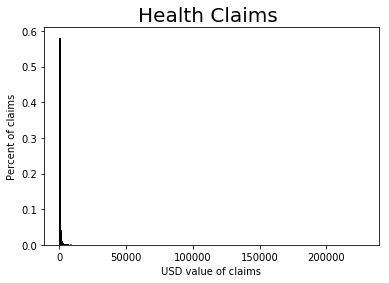

Heights sum to:  1.0000000000000329


In [3]:
# This next command is specifically for Jupyter Notebook
# %matplotlib notebook
%matplotlib inline

num_bins1 = 1000
w = np.ones_like(claims)/(len(claims))
count, bins, ignored =  plt.hist(claims, num_bins1, edgecolor='k',  weights = w)
plt.title('Health Claims ', fontsize=20)
plt.xlabel(r'USD value of claims')
plt.ylabel(r'Percent of claims')
plt.show()
print("Heights sum to: ",sum(count))

(10619, 1) (9020,)


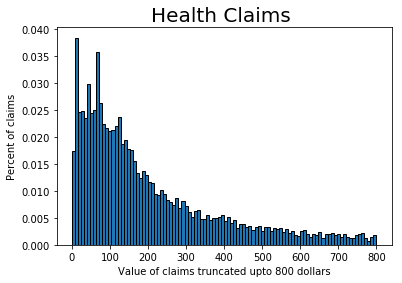

Heights sum to:  0.8494208494208462


In [4]:
# This next command is specifically for print(claims.shape, claims_tr.shape)
# %matplotlib notebook
%matplotlib inline

num_bins2 = 100
claim_tr = np.ravel(claims[claims<=800])
print(claims.shape, claim_tr.shape)
w = np.ones_like(claim_tr)/(len(claims))
count, bins, ignored =  plt.hist(claim_tr,num_bins2, edgecolor='k', weights =  w)
plt.title('Health Claims ', fontsize=20)
plt.xlabel(r'Value of claims truncated upto 800 dollars')
plt.ylabel(r'Percent of claims')
plt.show()
print("Heights sum to: ",sum(count))

Now let's create a distribution around these data that we think fits it well.

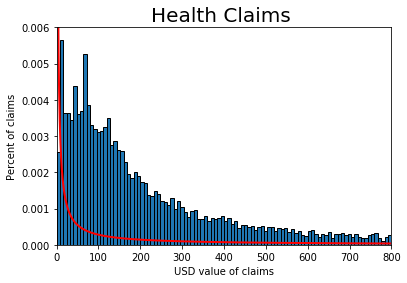

In [5]:
# Define function that generates values of a normal pdf
beta = cl_var/cl_mean
alpha =  cl_mean/beta

def gamma_pdf(xvals,alpha, beta):
    inter= math.gamma(alpha)
    pdf_vals    = ((beta**(-1*alpha))/inter)*(xvals**(alpha-1))*np.exp(-1*(xvals/beta))
    return pdf_vals

num_bins1 = 100
w = np.ones_like(claims)/(len(claims))
count, bins, ignored =  plt.hist(claim_tr, num_bins1, edgecolor='k',density = True)
plt.title('Health Claims ', fontsize=20)
plt.xlabel(r'USD value of claims')
plt.ylabel(r'Percent of claims')

dist_claims = np.linspace(min(claim_tr),max(claim_tr), 10000)
plt.plot(dist_claims, gamma_pdf(dist_claims, alpha,beta),linewidth=2, color='r')
plt.ylim([0, .006]) 
plt.xlim([0, 800]) 
# plt.legend(loc='upper left')
# , label='1: $\Alpha$=alpha,$\Beta$=beta'
plt.show()

In [6]:
# Define log likelihood function for the normal distribution
def log_lik_gamma(xvals,alpha, beta):
    pdf_vals = gamma_pdf(xvals,alpha, beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    return log_lik_val

print('Log-likelihood 1: ', log_lik_gamma(claims,alpha, beta))


Log-likelihood 1:  -93556.2543421563


In [7]:
def crit(params,*args):
    alpha, beta = params
    xvals = args
    log_lik_val = log_lik_gamma(xvals, alpha,beta)
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

In [8]:
import scipy.optimize as opt 
alpha_init = alpha  
beta_init = beta
params_init = np.array([alpha_init, beta_init])
mle_args = (claims)
results_uncstr = opt.minimize(crit, params_init, args = mle_args,method = 'L-BFGS-B', bounds = ((1e-15, None), (1e-15, None)))
alpha_MLE, beta_MLE = results_uncstr.x
like =  -results_uncstr.fun
print('alpha_MLE=', alpha_MLE, ' beta_MLE=', beta_MLE,' log_likelihood=',like)
print(alpha,beta)

alpha_MLE= 0.22175096367057023  beta_MLE= 21913.1282767136  log_likelihood= -82076.64049645475
[0.0328697] [21913.12828014]


In [9]:
results_uncstr

      fun: 82076.64049645475
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00145519, 0.09022187])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 8
   status: 0
  success: True
        x: array([2.21750964e-01, 2.19131283e+04])

(0, 800)

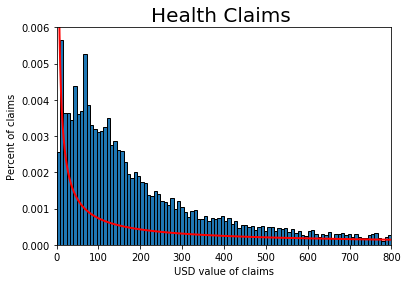

In [10]:
# Plot the histogram of the data
num_bins1 = 100
w = np.ones_like(claims)/(len(claims))
count, bins, ignored =  plt.hist(claim_tr, num_bins1, edgecolor='k',density = True)
plt.title('Health Claims ', fontsize=20)
plt.xlabel(r'USD value of claims')
plt.ylabel(r'Percent of claims')
# Plot the MLE estimated distribution
dist_claims = np.linspace(min(claim_tr),max(claim_tr), 10000)
plt.plot(dist_claims, gamma_pdf(dist_claims, alpha_MLE,beta_MLE),linewidth=2, color='r')
plt.ylim([0, .006]) 
plt.xlim([0, 800]) 

## Starting with 1c with Generalized Gamma

(0, 800)

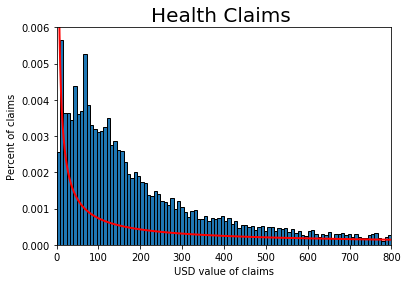

In [11]:
alpha = alpha_MLE
beta = beta_MLE
m =1

def g_gamma_pdf(xvals,alpha, beta,m):
    inter= math.gamma(alpha/m)
    pdf_vals    = (m*(beta**(-1*alpha))/inter)*(xvals**(alpha-1))*np.exp(-1*((xvals/beta)**m))
    return pdf_vals

num_bins1 = 100
w = np.ones_like(claims)/(len(claims))
count, bins, ignored =  plt.hist(claim_tr, num_bins1, edgecolor='k',density = True)
plt.title('Health Claims ', fontsize=20)
plt.xlabel(r'USD value of claims')
plt.ylabel(r'Percent of claims')

dist_claims = np.linspace(min(claim_tr),max(claim_tr), 10000)
plt.plot(dist_claims, g_gamma_pdf(dist_claims, alpha,beta,m),linewidth=2, color='r')
plt.ylim([0, .006]) 
plt.xlim([0, 800]) 

In [12]:
# Define log likelihood function for the normal distribution
def log_lik_g_gamma(xvals,alpha, beta,m):
    pdf_vals = g_gamma_pdf(xvals,alpha, beta,m)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    return log_lik_val

print('Log-likelihood 1: ', log_lik_g_gamma(claims,alpha, beta,m))



Log-likelihood 1:  -82076.64049645475


In [13]:
def crit_gg(params,*args):
    alpha, beta,m = params
    xvals = args
    log_lik_val = log_lik_g_gamma(xvals, alpha,beta,m)
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

In [14]:
alpha_init = alpha_MLE 
beta_init = beta_MLE
m_init = 1
params_init = np.array([alpha_init, beta_init,m_init])
mle_args = (claims)
results_uncstr = opt.minimize(crit_gg, params_init, args = mle_args,method = 'L-BFGS-B', bounds = ((1e-15, None), (1e-15, None),(1e-15, None)))
alpha_MLE_gg, beta_MLE_gg, m_MLE_gg = results_uncstr.x
like =  -results_uncstr.fun
print('alpha_MLE_gg=', alpha_MLE_gg, ' beta_MLE_gg=', beta_MLE_gg,' m_MLE=', m_MLE_gg,' log_likelihood=',like)
print(alpha_MLE,beta_MLE,m_init)

alpha_MLE_gg= 0.22176058742383808  beta_MLE_gg= 21913.128008324402  m_MLE= 0.9970557539915825  log_likelihood= -82076.63563075103
0.22175096367057023 21913.1282767136 1


In [15]:
results_uncstr

      fun: 82076.63563075103
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.61352398,  0.09022187, -1.09139364])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 2
   status: 0
  success: True
        x: array([2.21760587e-01, 2.19131280e+04, 9.97055754e-01])

(0, 800)

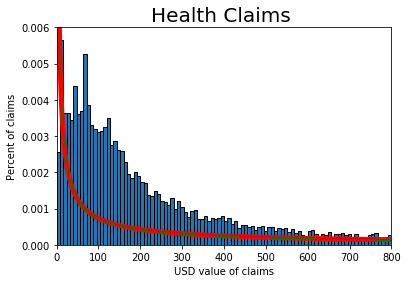

In [16]:
# Plot the histogram of the data
num_bins1 = 100
w = np.ones_like(claims)/(len(claims))
count, bins, ignored =  plt.hist(claim_tr, num_bins1, edgecolor='k',density = True)
plt.title('Health Claims ', fontsize=20)
plt.xlabel(r'USD value of claims')
plt.ylabel(r'Percent of claims')
# Plot the MLE estimated distribution
dist_claims = np.linspace(min(claim_tr),max(claim_tr), 10000)
plt.plot(dist_claims, g_gamma_pdf(dist_claims, alpha_MLE_gg,beta_MLE_gg,m_MLE_gg),linewidth=5, color='r')
plt.plot(dist_claims, gamma_pdf(dist_claims, alpha_MLE,beta_MLE), 'g*', markersize = .1)
plt.ylim([0, .006]) 
plt.xlim([0, 800]) 

## Starting with 1d with 2 Generalized Beta

(0, 800)

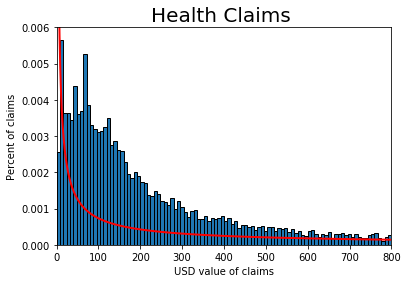

In [17]:
from scipy.special import beta

q = 200
a = m_MLE_gg
b = q**(1/a)*beta_MLE_gg
p = alpha_MLE_gg/a


def GB_pdf(x,a, b,p,q):
    num1= a*(x**(a*p-1))
    den1 = beta(p, q)
#     den1 = math.gamma(p)* math.gamma(q)/ math.gamma(p+q)
    den2 = (b**(a*p))*((1 + (x/b)**a)**(p+q))
    pdf_vals    = (num1/(den1*den2))
    return pdf_vals

num_bins1 = 100
w = np.ones_like(claims)/(len(claims))
count, bins, ignored =  plt.hist(claim_tr, num_bins1, edgecolor='k',density = True)
plt.title('Health Claims ', fontsize=20)
plt.xlabel(r'USD value of claims')
plt.ylabel(r'Percent of claims')

dist_claims = np.linspace(min(claim_tr),max(claim_tr), 10000)
plt.plot(dist_claims, GB_pdf(dist_claims, a,b,p,q),linewidth=2, color='r')
plt.ylim([0, .006]) 
plt.xlim([0, 800]) 

In [18]:
# Define log likelihood function for the normal distribution
def log_lik_GB(x,a,b,p,q):
    pdf_vals = GB_pdf(x,a,b,p,q)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    return log_lik_val

print('Log-likelihood 1: ', log_lik_GB(claims,a,b,p,q))



Log-likelihood 1:  -82080.74400588757


In [19]:
def crit_GB(params,*args):
    a, b,p,q = params
    x = args
    log_lik_val = log_lik_GB(x,a,b,p,q)
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

In [20]:
q_init = 200
a_init = m_MLE_gg
b_init = q**(1/a_init)*beta_MLE_gg
p_init = alpha_MLE_gg/a_init
params_init = np.array([a_init, b_init,p_init,q_init])
mle_args = (claims)
results_uncstr = opt.minimize(crit_GB, params_init, args = mle_args,method = 'L-BFGS-B', bounds = ((1e-15, None), (1e-15, None),(1e-15, None),(1e-15, None)), tol = 1e-14)
a_MLE_GB, b_MLE_GB, p_MLE_GB,q_MLE_GB = results_uncstr.x
like =  -results_uncstr.fun
print('a_MLE_GB=', a_MLE_GB, ' b_MLE_GB=', b_MLE_GB, ' p_MLE_GB=', p_MLE_GB,' q_MLE_GB=', q_MLE_GB,' log_likelihood=',like)

a_MLE_GB= 0.10709308287849512  b_MLE_GB= 4451733.680994309  p_MLE_GB= 51.626237183989936  q_MLE_GB= 151.07187313089153  log_likelihood= -74877.38640466922


In [21]:
results_uncstr

      fun: 74877.38640466922
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.49891309e+02,  0.00000000e+00, -9.41508915e-01, -9.74978320e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 935
      nit: 99
   status: 0
  success: True
        x: array([1.07093083e-01, 4.45173368e+06, 5.16262372e+01, 1.51071873e+02])

(0, 800)

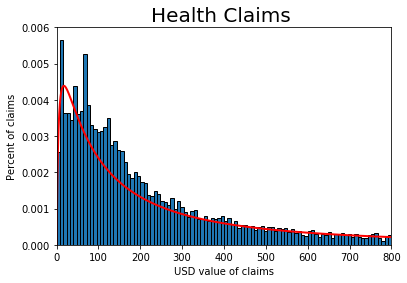

In [22]:
# Plot the histogram of the data
num_bins1 = 100
w = np.ones_like(claims)/(len(claims))
count, bins, ignored =  plt.hist(claim_tr, num_bins1, edgecolor='k',density = True)
plt.title('Health Claims ', fontsize=20)
plt.xlabel(r'USD value of claims')
plt.ylabel(r'Percent of claims')
# Plot the MLE estimated distribution
dist_claims = np.linspace(min(claim_tr),max(claim_tr), 10000)
plt.plot(dist_claims, GB_pdf(dist_claims,a_MLE_GB, b_MLE_GB, p_MLE_GB,q_MLE_GB ),linewidth=2, color='r')
plt.ylim([0, .006]) 
plt.xlim([0, 800]) 

# Hypothesis Testing

In [23]:
#hyp between GB  and Gamma

log_lik_h0 = -log_lik_GB(claim_tr,a_MLE_GB, b_MLE_GB, p_MLE_GB,q_MLE_GB)
log_lik_mle_ga = -log_lik_gamma(claim_tr, alpha_MLE, beta_MLE)
LR_val = 2 * (log_lik_mle_ga - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


In [24]:
#hyp between GB and Generalized Gamma

log_lik_h0 = -log_lik_GB(claim_tr,a_MLE_GB, b_MLE_GB, p_MLE_GB,q_MLE_GB)
log_lik_mle_gg = -log_lik_g_gamma(claim_tr, alpha_MLE_gg,beta_MLE_gg,m_MLE_gg)
LR_val = 2 * (log_lik_mle_gg - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


# Probability calculation

In [25]:
from scipy import integrate as integ
prob_GB= integ.quad(GB_pdf,1000, np.inf,args = (a_MLE_GB, b_MLE_GB, p_MLE_GB,q_MLE_GB))
                                                              
prob_GA = integ.quad(gamma_pdf, 1000, np.inf, args = (alpha_MLE, beta_MLE))

print("Probability healthcare : ", prob_GB[0])
print("Probability_GA of healthcare claim above 1000: ", prob_GA[0])

Probability healthcare :  0.1314852956626051
Probability_GA of healthcare claim above 1000:  0.4519639472347076


# Problem 2

In [26]:
# Load the data as a NumPy array
mac_data = pd.read_csv('MacroSeries.txt', header = None)
mac_data.columns = ['c','k','w','r','y'] 
mac_data.sample(10)

,c,k,w,r,y
93,8.598244e+06,5.551202e+06,8.536428e+06,1.113552,1.471798e+07
89,1.040309e+07,8.520946e+06,1.032830e+07,0.877733,1.780741e+07
60,1.020448e+07,7.493205e+06,1.013112e+07,0.979064,1.746744e+07
12,9.511900e+06,6.794606e+06,9.443516e+06,1.006446,1.628192e+07
22,5.656582e+06,4.924307e+06,5.615915e+06,0.825842,9.682612e+06
53,1.001540e+07,6.590330e+06,9.943394e+06,1.092569,1.714378e+07
15,8.842135e+06,6.109025e+06,8.778566e+06,1.040574,1.513546e+07
3,9.711635e+06,7.809971e+06,9.641815e+06,0.893986,1.662382e+07
24,5.425924e+06,3.789993e+06,5.386915e+06,1.029255,9.287784e+06
88,1.197195e+07,9.593783e+06,1.188588e+07,0.897145,2.049290e+07


In [27]:
def get_z3(alpha,w,k):
    return np.log(1/(1-alpha)* w * (k**(-alpha)))

def get_like(params, *args):
    w,k = args
    alpha,rho,mu,sigma = params
    z = get_z3(alpha,w,k)
    log_like_array = np.zeros_like(z)
    for i in range(len(z)):
        if i == 0:
            log_like_array[i] =  sts.norm.pdf(mu, loc = mu,scale = sigma)
        else:
            log_like_array[i] = sts.norm.pdf( z[i],loc = rho*z[i-1] + (1-rho)*mu,scale = sigma)
    log_sum =  - np.sum(np.log(log_like_array))
    return log_sum

In [28]:
alpha_init = 0.55
rho_init = 0.8
mu_init = 8.1 # mu_2
sig_init = .1 # sig_2

params_init = np.array([alpha_init, rho_init, mu_init, sig_init])
w = np.ravel(np.array(mac_data[['w']]))
k = np.ravel(np.array(mac_data[['k']]))
mle_args = (w, k)
results_uncstr = opt.minimize(get_like, params_init, args=(mle_args),method = 'L-BFGS-B',bounds = ((0.01,0.99),(-.99,.99),(1e-15,None),(1e-15,None)))
results_uncstr
# alpha_MLE, rho_MLE, mu_MLE, sig_MLE= results_uncstr.x
# print("alpha : " , alpha_MLE)
# print("rho : " , rho_MLE)
# print("mu : ",  mu_MLE)
# print("sigma : "  , sig_MLE)

      fun: -95.85827568459776
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00277822, 0.00134861, 0.00018332, 0.00178204])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 110
      nit: 19
   status: 0
  success: True
        x: array([0.55339012, 0.82466357, 8.10673467, 0.09278034])

In [29]:
def get_z4(alpha,r,k):
    a = -(alpha-1)
    return np.log(r/alpha *(k**a))

def get_like(params, *args):
    r,k = args
    alpha,rho,mu,sigma = params
    z = get_z4(alpha,r,k)
    log_like_array = np.zeros_like(z)
    for i in range(len(z)):
        if i == 0:
            log_like_array[i] =  sts.norm.pdf(mu, loc = mu,scale = sigma)
        else:
            log_like_array[i] = sts.norm.pdf( z[i],loc = rho*z[i-1] + (1-rho)*mu,scale = sigma)
    log_sum =  - np.sum(np.log(log_like_array))
    return log_sum

In [30]:
alpha_init = 0.5
rho_init = 0.8
mu_init = 8.0  # mu_2
sig_init = .1  # sig_2

params_init = np.array([alpha_init, rho_init, mu_init, sig_init])
r = np.ravel(np.array(mac_data[['r']]))
k = np.ravel(np.array(mac_data[['k']]))
mle_args = (r, k)
results_uncstr = opt.minimize(get_like, params_init, args=(mle_args))
results_uncstr
# alpha_MLE, rho_MLE, mu_MLE, sig_MLE= results_uncstr.x
# print("alpha : " , alpha_MLE)
# print("rho : " , rho_MLE)
# print("mu : ",  mu_MLE)
# print("sigma : "  , sig_MLE)

      fun: -95.85827568529145
 hess_inv: array([[ 3.04178790e-05,  2.42671029e-04, -3.46941815e-04,
        -4.94229669e-05],
       [ 2.42671029e-04,  3.58498691e-03, -4.20479117e-03,
        -4.29314052e-04],
       [-3.46941815e-04, -4.20479117e-03,  6.18673161e-03,
         4.95394795e-04],
       [-4.94229669e-05, -4.29314052e-04,  4.95394795e-04,
         3.99882416e-04]])
      jac: array([ 1.41811371e-03,  9.82284546e-05,  7.91549683e-05, -4.79221344e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 334
      nit: 18
     njev: 54
   status: 2
  success: False
        x: array([0.55338706, 0.82466105, 7.56963688, 0.09278005])

# Problem 3-GMM

In [32]:
income = pd.read_csv('usincmoms.txt', delimiter ='\t' ,header=None)
income.columns = ['share', 'average']
income

,share,average
0,0.035190,2500
1,0.041062,7500
2,0.058859,12500
3,0.056836,17500
4,0.058595,22500
5,0.054433,27500
6,0.055060,32500
7,0.050675,37500
8,0.047859,42500
9,0.040839,47500


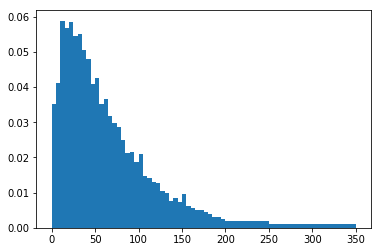

In [33]:
ybar = income.share.copy()
ybar[40] = income.share[40]/10
ybar[41] = income.share[41]/20
w = np.ones(42)*5
w[40] = w[40]*10
w[41] = w[41]*20
plt.bar(income.average/1000, ybar, width=w)
plt.show()

3.8934456123479406 0.9757364308992181


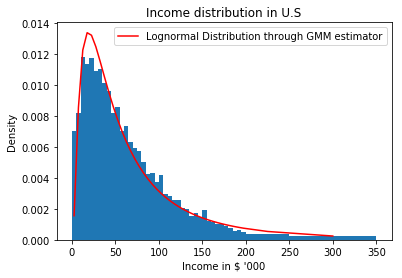

In [77]:
perc = np.ravel(np.array(income.share))
mid = np.ravel(np.array(income.average))/1000

def pdf_lognormal(x, mu, sigma):
    f = ((1/(x*sigma*np.sqrt(2*np.pi))))*np.exp((-((np.log(x) - mu)**2)/(2*sigma**2)))
    return f
    
def dist_moments(mu, sigma):
    bins = np.append(np.linspace(0,200,41), [250,350])
    N = len(bins)
    moments = np.zeros(N-1)
    for i in range(N-1):
        moments[i] = intgr.quad(pdf_lognormal, bins[i], bins[i+1], args=(mu,sigma))[0]
    return moments

def error_func(mu, sigma, absolute):
    if absolute==True:
        error = (dist_moments(mu, sigma) - perc)
    else:
        error = (dist_moments(mu, sigma) - perc)/perc
    return error

def crit_func(params, *args):
    mu, sigma = params
    W, absolute = args
    error = error_func(mu, sigma, absolute)
    crit = (error.T)@W@error
    return crit

def GMM_estimate(perc):
    bins = np.append(np.linspace(0,200,41), [250,350])
    W = np.diag(perc)
    mu_init = np.log(70000)
    sigma_init = .91
    params_init = np.array([mu_init, sigma_init])
    gmm_args = (W, False)
    results = opt.minimize(crit_func, params_init, 
                           args=(gmm_args),bounds=((None, None), (1e-10, None)), tol=1e-15)
    return results
    
results1= GMM_estimate(perc)
mu_GMM, sigma_GMM = results1.x
print(mu_GMM, sigma_GMM)
crit_GMM1 = results1.fun

ybar = income.share.copy()
ybar[40] = income.share[40]/10
ybar[41] = income.share[41]/20
ybar = ybar/5 # needs to be done to convert the histogram to a pdf where area under it sums to 1
w = np.ones(42)*5
w[40] = w[40]*10
w[41] = w[41]*20

y_dom_ln = pdf_lognormal(mid, mu_GMM, sigma_GMM)
plt.plot(mid, y_dom_ln, 'r',label="Lognormal Distribution through GMM estimator")


plt.bar(income.average/1000, ybar, width=w)
plt.xlabel("Income in $ '000")
plt.ylabel("Density")
plt.title("Income distribution in U.S")

plt.legend()
plt.show()

1.3670736464139415 48.06196437316253


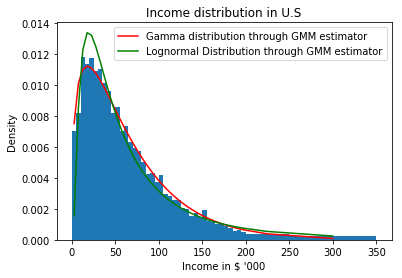

The minimized weighted error for  Lognormal is  0.036 and Gamma estimations are: 0.014
The GMM estimator has a better fit as it has lower minimum weighted error


In [86]:
perc = np.ravel(np.array(income.share))
mid = np.ravel(np.array(income.average))/1000


def gamma_pdf(x, alpha, beta):
    pdf = ((x)**(alpha-1))*(np.exp(-(x/beta)))/((beta**alpha)*math.gamma(alpha))
    return pdf


def dist_moments(alpha, beta):
    bins = np.append(np.linspace(0,200,41), [250,350])
    N = len(bins)
    moments = np.zeros(N-1)
    for i in range(N-1):
        moments[i] = intgr.quad(gamma_pdf, bins[i], bins[i+1], args=(alpha, beta))[0]
    return moments


def error_func(alpha, beta, absolute=1):
    if absolute==1:
        error = (dist_moments(alpha, beta) - perc)
    else:
        error = (dist_moments( alpha, beta) - perc)/perc
    return error

def crit_func(params, *args):
    alpha, beta = params
    W, absolute = args
    error = error_func(alpha, beta,absolute)
    crit = (error.T)@W@error
    return crit

def GMM_estimate_gamma(mid, perc):
#     bins = np.append(np.linspace(0,200,41), [250,350])
    mid = np.ravel(np.array(income.average))/1000
    W = np.diag(perc)
    alpha_init = 3
    beta_init = 20
    params_init = np.array([alpha_init, beta_init])
    gmm_args = (W, 0)
    results = opt.minimize(crit_func, params_init, args=(gmm_args), method = 'L-BFGS-B', bounds=((1e-10, None), (1e-10, None)), tol=1e-15)
    return results

results = GMM_estimate_gamma(mid, perc)
alpha_GMM, beta_GMM = results.x
print(alpha_GMM, beta_GMM)
crit_GMM_gamma = results.fun


ybar = income.share.copy()
ybar[40] = income.share[40]/10
ybar[41] = income.share[41]/20
ybar = ybar/5 # needs to be done to convert the histogram to a pdf where area under it sums to 1
w = np.ones(42)*5
w[40] = w[40]*10
w[41] = w[41]*20

y_dom = gamma_pdf(mid, alpha_GMM, beta_GMM)
plt.plot(mid, y_dom, 'r',label="Gamma distribution through GMM estimator")
y_dom_ln = pdf_lognormal(mid, mu_GMM, sigma_GMM)
plt.plot(mid, y_dom_ln, 'g',label="Lognormal Distribution through GMM estimator")

plt.bar(income.average/1000, ybar, width=w)
plt.xlabel("Income in $ '000")
plt.ylabel("Density")
plt.title("Income distribution in U.S")

plt.legend()
plt.show()
print('The minimized weighted error for  Lognormal is ', round(crit_GMM1,3),"and Gamma estimations are:" ,round(crit_GMM_gamma,3))
print('The GMM estimator has a better fit as it has lower minimum weighted error')

In [93]:
alpha_init = 4.0
beta_init = 20

params_init = np.array([alpha_init, beta_init])
gmm_args = ( np.eye(42),0)

results_2 = opt.minimize(crit_func, params_init, args=(gmm_args),method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)), tol=1e-15)

alpha_gmm_2, beta_gmm_2 = results_2.x

print(alpha_gmm_2, beta_gmm_2 )

C:\Anaconda\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


1.3743616610631852 46.21145290825851


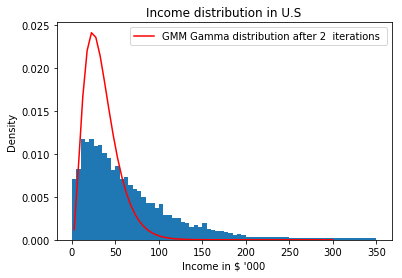

In [100]:
W_e = (1/len(mid))*np.outer(error_func(alpha_gmm_2, beta_gmm_2,0) ,error_func(alpha_gmm_2, beta_gmm_2,0))

gmm_args_e = (W_e,0)

results_e = opt.minimize(crit_func, params_init, args=(gmm_args_e), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)), tol=1e-15)

alpha_gmm_e, beta_gmm_e = results_e.x
results_e

y_dom = gamma_pdf(mid, alpha_gmm_e, beta_gmm_e)
plt.plot(mid, y_dom, 'r',label="GMM Gamma distribution after 2  iterations ")

plt.bar(income.average/1000, ybar, width=w)
plt.xlabel("Income in $ '000")
plt.ylabel("Density")
plt.title("Income distribution in U.S")

plt.legend()
plt.show()


In [101]:
mac_data = pd.read_csv('MacroSeries.txt', header = None)
mac_data.columns = ['c','k','w','r','y'] 
print(mac_data.shape)

def get_z(y,k,alpha):
    return np.log(y) - alpha*np.log(k)

def crit_brock(params, *args):
    alpha, beta, rho, mu = params
    y, k, c, w = args
    moments = np.zeros(4)
    z_t = get_z(y, k, alpha)
    z_tp1 = z_t[1:]
    z_t = z_t[:-1]
    k_tp1 = k[1:]
    c_tp1 = c[1:]
    c_t = c[:-1]
    w_t = w[:-1]
    moments[0] = np.mean(z_tp1 - rho*z_t - (1-rho)*mu)
    moments[1] = np.mean((z_tp1 - rho*z_t - (1-rho)*mu)*z_t)
    moments[2] = np.mean((beta*alpha*np.exp(z_tp1)*(k_tp1**(alpha-1))*(c_t/c_tp1))-1)
    moments[3] = np.mean(((beta*alpha*np.exp(z_tp1)*(k_tp1**(alpha-1))*(c_t/c_tp1))-1)*w_t)
    I = np.eye(4)
    error = moments.T @ I @ moments
    return error

def GMM_brock(mac_data):
    mac_data.columns = ['c','k','w','r','y'] 
    c_data = np.ravel(np.array(mac_data[['c']]))
    k_data = np.ravel(np.array(mac_data[['k']]))
    w_data = np.ravel(np.array(mac_data[['w']]))
    r_data = np.ravel(np.array(mac_data[['r']]))
    y_data = np.ravel(np.array(mac_data[['y']]))
    alpha_init = 0.5
    beta_init = 0.92
    rho_init = 0.8
    mu_init =0.5
    params_init = np.array([alpha_init, beta_init, rho_init, mu_init])
    gmm_args = y_data, k_data, c_data, w_data
    results = opt.minimize(crit_brock, params_init, args = (gmm_args), method= 'L-BFGS-B', bounds=((1e-3,0.99),(1e-2, None),(1e-3, None), (1e-3, None)), tol = 1e-15)
    return results

results = GMM_brock(mac_data)
alpha_GMM, beta_GMM, rho_GMM, mu_GMM = results.x
error = results.fun
print('alpha: ', round(alpha_GMM,3), ' ,beta: ', round(beta_GMM,3) , ' ,rho: ', round(rho_GMM,3) , ' ,mu: ', round(mu_GMM,3))
print('objective function error: ', round(error,3))

(100, 5)
alpha:  0.475  ,beta:  0.875  ,rho:  0.993  ,mu:  0.505
objective function error:  0.221


In [ ]:
mac_data = pd.read_csv('MacroSeries.txt', header = None)
mac_data.columns = ['c','k','w','r','y'] 
c_data = np.ravel(np.array(mac_data[['c']]))
k_data = np.ravel(np.array(mac_data[['k']]))
w_data = np.ravel(np.array(mac_data[['w']]))
r_data = np.ravel(np.array(mac_data[['r']]))
y_data = np.ravel(np.array(mac_data[['y']]))

def simulation(S, T, sigma, rho, mu):
    epsilon_matrix= np.zeros((T,S))
    for i in range(S):
        u = np.random.uniform(size=T)
        epsilon_matrix[:,i] = sts.norm.ppf(u, loc=0, scale=sigma)
    return epsilon_matrix

def generate_z(S, T, sigma, rho, mu):
    #Generating time series of Z_t given epsilon
    epsilon_matrix = simulation(S, T, sigma, rho, mu)
    z_matrix=np.zeros((T,S))
    z0= mu
    for j in range(S):
        for i in range(T):
            z_matrix[i,j] = rho*z0 + (1-rho)*mu + epsilon_matrix[i,j]
            z0 = z_matrix[i,j]
    print(z_matrix)
    return z_matrix
    
def generate_k(S, T, sigma, rho, mu, alpha, beta):
    z_matrix = generate_z(S, T, sigma, rho, mu)
    k_matrix=np.zeros((T+1,S))
    k0 = np.mean(k_data)
    k_matrix[0,:] = k0
    for i in range(1,T+1):
        k_matrix[i,:] = alpha*beta*np.exp(z_matrix[i-1,:])*(k_matrix[i-1,:])
    ktp1_matrix = k_matrix[1:, :]
    kt_matrix = k_matrix[:-1, :]
    return kt_matrix, ktp1_matrix
    
def generate_w(S, T, sigma, rho, mu, alpha, beta):
    k_matrix = generate_k(S, T, sigma, rho, mu, alpha, beta)[0]
    z_matrix = generate_z(S, T, sigma, rho, mu)
    w_matrix = (1-alpha)*np.exp(z_matrix)*(k_matrix)**alpha
    return w_matrix

def generate_r(S, T, sigma, rho, mu, alpha, beta):
    k_matrix = generate_k(S, T, sigma, rho, mu, alpha, beta)[0]
    z_matrix = generate_z(S, T, sigma, rho, mu)
    r_matrix = alpha*np.exp(z_matrix)*(k_matrix)**(alpha-1)
    return r_matrix

def generate_c(S, T, sigma, rho, mu, alpha, beta):
    kt_matrix, ktp1_matrix = generate_k(S, T, sigma, rho, mu, alpha, beta)
    w_matrix = generate_w(S, T, sigma, rho, mu, alpha, beta)
    r_matrix = generate_r(S, T, sigma, rho, mu, alpha, beta)
    c_matrix = w_matrix + r_matrix*kt_matrix - ktp1_matrix
    return c_matrix

def generate_y(S, T, sigma, rho, mu, alpha, beta):
    z_matrix= generate_z(S, T, sigma, rho, mu)
    k_matrix = generate_k(S, T, sigma, rho, mu, alpha, beta)[0]
    y_matrix = np.exp(z_matrix)*(k_matrix)**alpha
    return y_matrix

def moments_average(S, T, sigma, rho, mu, alpha, beta):
    c_matrix = generate_c(S, T, sigma, rho, mu, alpha, beta)
    y_matrix = generate_y(S, T, sigma, rho, mu, alpha, beta)
    k_matrix = generate_k(S, T, sigma, rho, mu, alpha, beta)[0]
    mom_1 = np.mean(np.mean(c_matrix, axis=0))
    mom_2 = np.mean(np.mean(k_matrix, axis=0))
    mom_3 = np.mean(np.mean(c_matrix/y_matrix, axis=0))
    mom_4 = np.mean(np.var(y_matrix, axis=0))
    correlate_c = np.zeros(S)
    correlate_k = np.zeros(S)
    c_tminus = c_matrix[1:, :]
    c_t = c_matrix[:-1, :]
    for i in range(S):
        correlate_c[i] = np.float(np.correlate(c_t[:,i], c_tminus[:,i]))
    mom_5 = np.mean(correlate_c)
    for i in range(S):
        correlate_k[i] = np.float(np.correlate(c_matrix[:,i], k_matrix[:,i]))
    mom_6 = np.mean(correlate_k)
    return mom_1, mom_2, mom_3, mom_4, mom_5, mom_6

def data_moments(c, k, y):
    data_mom1 = np.mean(c)
    data_mom2 = np.mean(k)
    data_mom3 = np.mean(c/y)
    data_mom4 = np.var(y)
    data_mom5 = np.correlate(c[:-1], c[1:])
    data_mom6 = np.correlate(c,k)
    return data_mom1, data_mom2, data_mom3, data_mom4, data_mom5, data_mom6

def error_func(S, T, sigma, rho, mu, alpha, beta, absolute):
    mom_1, mom_2, mom_3, mom_4, mom_5, mom_6 = moments_average(S, T, sigma, rho, mu, alpha, beta)
    model_moments = np.array([mom_1, mom_2, mom_3, mom_4, mom_5, mom_6])
    data_m1, data_m2, data_m3, data_m4, data_m5, data_m6 = data_moments(c_data, k_data, y_data)
    data_moms= np.array([data_m1, data_m2, data_m3, data_m4, data_m5, data_m6])
    if absolute==True:
        error = model_moments - data_moms
    if absolute == False:
        error = (model_moments - data_moms)/data_moms
    return error

def crit_SMM(params, *args):
    alpha, rho, mu, sigma = params
    S, T, beta, absolute = args
    W = np.identity(6)
    error = error_func(S, T, sigma, rho, mu, alpha, beta, absolute)
    criter = error.T@W@error
    return criter

alpha_init = 0.55
rho_init = 0.82
mu_init = 8.0
sigma_init = 0.1
params_init = np.array([alpha_init, rho_init, mu_init, sigma_init])
args_guess = 1000,100, 0.99, False
results_SMM = opt.minimize(crit_SMM, params_init, args=(args_guess), 
                           bounds = ((0.01,0.99), (None,None), (1e-2,None), (0.01,None)),tol = 1e-15)

print(results_SMM)